In [ ]:
# convert a video into its animated form

In /home/linuxdualboot/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/linuxdualboot/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/linuxdualboot/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


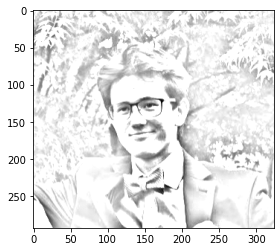

In [24]:
# first try this with an image


root_path = '/home/linuxdualboot/github/misc projects/lover'
os.chdir(root_path)

from PIL import Image 
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
import cv2
import glob


def dodge(front,back):
    result=front*255/(255-back) 
    result[result>255]=255
    result[back==255]=255
    return result.astype('uint8')

def grayscale(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


img ="picture.jpg"
video ="video.mp4"


s = imageio.imread(img)
g=grayscale(s)
i = 255-g
import scipy.ndimage
b = scipy.ndimage.filters.gaussian_filter(i,sigma=10)
r= dodge(b,g)


%matplotlib inline 
plt.imshow(r, cmap="gray")


plt.imsave('img2.png', r, cmap='gray', vmin=0, vmax=255)



In [25]:
path = os.getcwd() + '/video'

try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)

Creation of the directory /home/linuxdualboot/github/misc projects/lover/video failed


In [26]:
os.chdir(root_path)
vidcap = cv2.VideoCapture('video.mp4')
success,image = vidcap.read()
os.chdir(root_path + '/video')
count = 0
while success:
    if count % 30 == 0:
        cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
        # print('Read a new frame: ', success)
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  False


/home/linuxdualboot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/linuxdualboot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/linuxdualboot/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


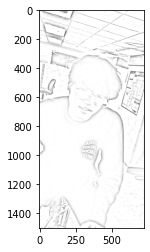

In [27]:
for filename in os.listdir(root_path+'/video'):
    if filename.endswith(".jpg"): 
        img = filename 
        s = imageio.imread(img)
        g=grayscale(s)
        i = 255-g
        b = scipy.ndimage.filters.gaussian_filter(i,sigma=10)
        r= dodge(b,g)
        os.remove(filename) 
        plt.imsave(filename, r, cmap='gray', vmin=0, vmax=255)
        %matplotlib inline 
        plt.imshow(r, cmap="gray")


In [38]:
 
img_array = []
for filename in glob.glob(root_path + '/video/*.jpg'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
 
out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 3, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()